# `xvr` tutorial

1. Connect to a GPU: `Runtime > Change runtime type > T4 GPU`
2. Install `xvr`
3. Download data and pretrained models

In [ ]:
!pip install git+https://github.com/eigenvivek/xvr.git --upgrade

  Cloning https://github.com/eigenvivek/xvr.git to /tmp/pip-req-build-hued0iim
  Running command git clone --filter=blob:none --quiet https://github.com/eigenvivek/xvr.git /tmp/pip-req-build-hued0iim
  Resolved https://github.com/eigenvivek/xvr.git to commit af8287cd6d8cf0bad4cb07d746a5fff7b1eeaecb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
!pip install git+https://github.com/eigenvivek/DiffDRR.git

!pip install nibabel pydicom matplotlib tqdm


  Cloning https://github.com/eigenvivek/DiffDRR.git to /tmp/pip-req-build-8mfixzyh
  Running command git clone --filter=blob:none --quiet https://github.com/eigenvivek/DiffDRR.git /tmp/pip-req-build-8mfixzyh
  Resolved https://github.com/eigenvivek/DiffDRR.git to commit f77697bdb310ad9a28777b2e131970fbc1bafb7a
  Preparing metadata (setup.py) ... done
  Created wheel for diffdrr: filename=diffdrr-0.6.0rc1-py3-none-any.whl size=34802742 sha256=454a7141f3689d9ce74a3487128587cb1dc1edc1198d1200414b5bcf75ee172e
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lthihd0/wheels/70/73/7f/378dd03aa4bd2a4c42c4a652028a9a01dcff775face2ac4a2b
Successfully built diffdrr
  Attempting uninstall: diffdrr
    Found existing installation: diffdrr 0.5.1
    Uninstalling diffdrr-0.5.1:
      Successfully uninstalled diffdrr-0.5.1


## Install `xvr`

In [ ]:
!xvr --version

xvr, version 0.0.0rc1


## Test-time optimization

Here, we show how to iteratively refine the initial poses estimated by a patient-specific neural network.

In [ ]:
!HF_HUB_DISABLE_PROGRESS_BARS=TRUE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffdrr.pose import RigidTransform
from huggingface_hub import snapshot_download

from xvr.metrics import Evaluator
from xvr.registrar import RegistrarModel
from xvr.utils import XrayTransforms
from xvr.visualization import plot_registration

In [ ]:
import matplotlib.pyplot as plt
import torch
from diffdrr.visualization import plot_drr
from xvr.metrics import Evaluator
from xvr.utils import XrayTransforms
from diffdrr.pose import RigidTransform

def plot_registration(drr, fiducials, gt, pred_pose, true_pose):
    """
    Visualize registration results:
    - Uses unflipped pred_pose for DRR rendering (ensures valid image)
    - Uses flipped pred_pose for fiducial projection and mTRE calculation (ensures alignment)
    """
    # Step 1: Flip a copy of the predicted pose for fiducial projection & evaluation
    flipped_pose = RigidTransform(matrix=pred_pose.matrix.clone())
    # flipped_pose.matrix[0, 0, 3] *= -1  # Flip X translation
    flipped_pose.matrix[0, 1, 3] *= -1  # Flip Y translation
    # flipped_pose.matrix[0, 2, 3] *= -1  # Flip Z translation


    # Step 2: Evaluate mTRE using pose
    evaluator = Evaluator(drr, fiducials)
    mtre = evaluator(true_pose, flipped_pose)[2]

    # Step 3: Generate DRRs and project fiducials
    with torch.no_grad():
        pred_img = drr(pred_pose).cpu()
        true_img = drr(true_pose).cpu()
        error = (true_img - pred_img)

        pred_pts = drr.perspective_projection(flipped_pose, fiducials).cpu().squeeze()
        true_pts = drr.perspective_projection(true_pose, fiducials).cpu().squeeze()

    xt = XrayTransforms(drr.detector.height, drr.detector.width)
    gt = xt(gt)
    pred_img = xt(pred_img)

    axs = plot_drr(torch.concat([pred_img, gt, error]))

    axs[1].scatter(true_pts[..., 0], true_pts[..., 1], color="dodgerblue", label="True")
    axs[1].scatter(pred_pts[..., 0], pred_pts[..., 1], color="darkorange", label="Pred")
    for x, y in zip(pred_pts, true_pts):
        axs[1].plot([x[0], y[0]], [x[1], y[1]], "w--", linewidth=0.8)
    axs[1].legend()

    plot_drr(
        torch.concat([pred_img, gt, error]),
        title=[
            "DRR from Predicted Pose",
            "Ground truth X-ray",
            f"Error (mTRE = {mtre:.2f} mm)"
        ],
        ticks=False,
        axs=axs,
    )

    axs[2].imshow(
        error[0].permute(1, 2, 0),
        cmap="bwr",
        vmin=-error.abs().max(),
        vmax=error.abs().max()
    )

    plt.tight_layout()
    plt.show()


## Evaluating pretrained models

Here, we are using the pretrained models and testing them using our Femur CT data and x ray image to find the pose value.

In [ ]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm

#Model Evaluation

In [ ]:
true_pose = torch.load("/content/drive/MyDrive/Trained Registration model/prox 2.17 spacing /1436x1436 prox pose.pt", weights_only=False).cuda()

print("True Pose:",true_pose.matrix)

True Pose: tensor([[[  1.,   0.,   0.,   9.],
         [  0.,   1.,   0.,  35.],
         [  0.,   0.,   1., 170.],
         [  0.,   0.,   0.,   1.]]], device='cuda:0')


In [ ]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    """
    Converts a 4x4 homogeneous pose matrix to Euler angles and translation vector.

    Args:
        pose_matrix (torch.Tensor): shape [4, 4] or [1, 4, 4]
        convention (str): e.g., "ZXY"
        degrees (bool): Return angles in degrees (True) or radians (False)

    Returns:
        euler_angles (torch.Tensor): shape [3] (rx, ry, rz)
        translation (torch.Tensor): shape [3] (x, y, z)
    """
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].cpu().numpy()
    t_vec = pose_matrix[:3, 3].cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(true_pose.matrix, convention="ZXY", degrees=True)
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Rotation angles (ZXY) in degrees: tensor([0., 0., 0.])
Translation (mm): tensor([  9.,  35., 170.])


In [ ]:
# Load the ground truth 3D fiducials
fiducials = torch.load("/content/drive/MyDrive/Trained Registration model/prox 2.17 spacing /1436x1436 prox fiducials.pt", weights_only=False).cuda()
# fiducials = fiducials.unsqueeze(0)  # Adds a batch dimension at dim=0

In [ ]:
print("Fiducials",fiducials)

Fiducials tensor([[[ 304.6987, -985.0000,   56.7922],
         [ -64.6362, -985.0000,  531.6514],
         [  -5.2788, -985.0001,  815.2478],
         [ -84.4220, -985.0000,  663.5565],
         [ 185.9839, -985.0000,  234.8644],
         [-579.0668, -985.0000,  201.8880],
         [ 153.0076, -985.0000, -437.8526],
         [-295.4704, -985.0000, -193.8279],
         [ 509.1519, -985.0000,  656.9613],
         [ 423.4135, -985.0001, 1085.6537],
         [ 430.0088, -985.0001, 1408.8217],
         [ 133.2217, -985.0001, 1639.6558],
         [ 139.8170, -985.0001, 1422.0121],
         [ 106.8407, -985.0001, 1052.6770],
         [ 700.4147, -985.0000, -108.0894],
         [-691.1863, -985.0000, -787.4017],
         [ 416.8182, -985.0001, 1613.2748]]], device='cuda:0')


Dataset.file_meta -------------------------------
(0002,0002) Media Storage SOP Class UID         UI: X-Ray Angiographic Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.31894388350517556834212474979160233441
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002,0013) Implementation Version Name         SH: 'PYDICOM 2.4.4'
-------------------------------------------------
(0008,0016) SOP Class UID                       UI: X-Ray Angiographic Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.31894388350517556834212474979160233441
(0008,0020) Study Date                          DA: '20250626'
(0008,0030) Study Time                          TM: '195016'
(0008,0060) Modality                            CS: 'OT'
(0010,0010) Patient's Name                      PN: 'Synthetic'
(0010,0020) Patient ID   

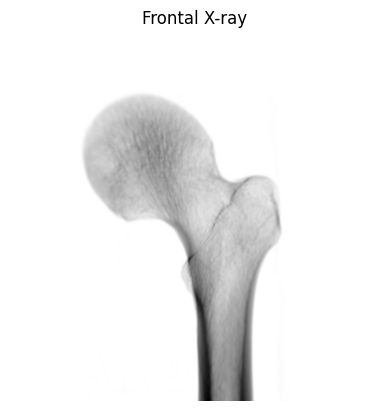

In [ ]:
import pydicom
import matplotlib.pyplot as plt
from pathlib import Path

dicom_img = pydicom.dcmread("/content/drive/MyDrive/Trained Registration model/prox 2.17 spacing /1436x1436 prox.dcm")

# Print metadata
print(dicom_img)

# Display the image
plt.imshow(dicom_img.pixel_array, cmap='gray')
plt.title("Frontal X-ray")
plt.axis('off')
plt.show()


In [ ]:
model_agnostic = RegistrarModel(
        volume="/content/drive/MyDrive/xrays/SE000002.nii.gz",
        mask=None,
        # ckptpath="trained-new-paths/finetuned02_10ep.pth",
        # ckptpath = "/content/drive/MyDrive/Trained Registration model/Finetuned/Agnostic Fine tuned Default Parameter/xvr_0005.pth", # Best for full bone
        ckptpath = "/content/drive/MyDrive/Trained Registration model/Scratch/patient_se000002_longtrain_0230.pth",
        crop=0,
        init_only=False,
    )

In [ ]:
# Demonstrate the patient-agnostic model
gt, _, drr, init_pose, final_pose, _ = model_agnostic.run("/content/drive/MyDrive/Trained Registration model/prox 2.17 spacing /1436x1436 prox.dcm", beta=0.5)


Stage 1:   6%|██▍                                     | 31/500 [00:01<00:26, 17.90it/s, ncc = 0.031]


In [ ]:
print("Initial Pose:",init_pose.matrix)
print(type(init_pose))

Initial Pose: tensor([[[ 9.9802e-01, -1.3621e-02,  6.1417e-02, -1.0854e+01],
         [ 1.7435e-02,  9.9792e-01, -6.1999e-02, -4.7241e+02],
         [-6.0445e-02,  6.2947e-02,  9.9618e-01, -1.8368e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')
<class 'diffdrr.pose.RigidTransform'>


In [ ]:
print("Final Pose:",final_pose.matrix)
print(type(final_pose))

Final Pose: tensor([[[ 9.9988e-01,  9.3465e-03,  1.2344e-02, -1.3972e+01],
         [-8.4942e-03,  9.9769e-01, -6.7377e-02, -4.7533e+02],
         [-1.2945e-02,  6.7264e-02,  9.9765e-01, -2.4478e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0', grad_fn=<CopySlices>)
<class 'diffdrr.pose.RigidTransform'>


In [ ]:
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].cpu().numpy()
    t_vec = pose_matrix[:3, 3].cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(init_pose.matrix, convention="ZXY", degrees=True)
# Output
print("Predicted 6 DOF Initial Pose of the X-Ray image")
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Predicted 6 DOF Initial Pose of the X-Ray image
Rotation angles (ZXY) in degrees: tensor([1.0009, 3.5546, 3.5280])
Translation (mm): tensor([ -10.8540, -472.4091,  -18.3681])


In [ ]:
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].detach().cpu().numpy()
    t_vec = pose_matrix[:3, 3].detach().cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(final_pose.matrix, convention="ZXY", degrees=True)
# Output
print("Predicted 6 DOF Final Pose of the X-Ray image")
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Predicted 6 DOF Final Pose of the X-Ray image
Rotation angles (ZXY) in degrees: tensor([-0.4878,  3.8634,  0.7089])
Translation (mm): tensor([ -13.9724, -475.3294,  -24.4775])


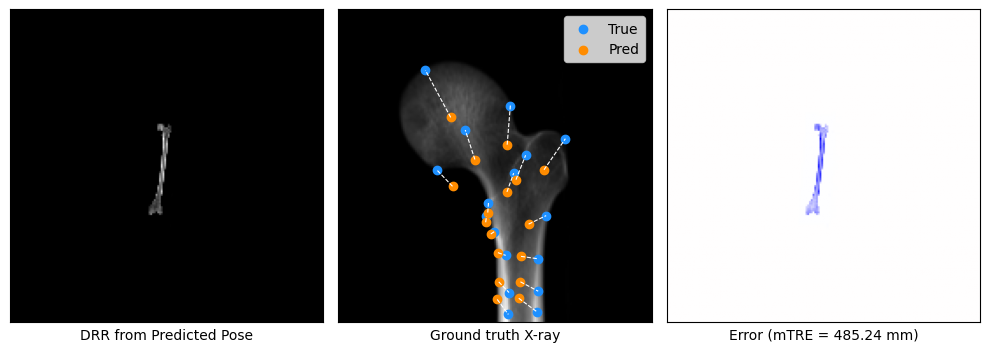

In [ ]:
plot_registration(drr, fiducials, gt, init_pose, true_pose)

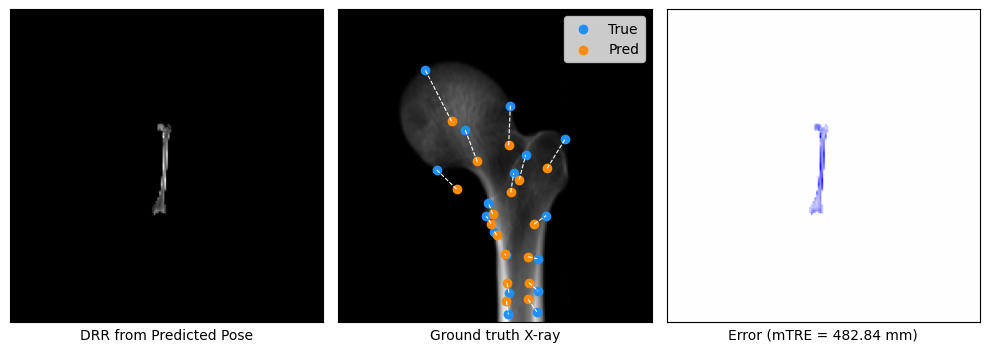

In [ ]:
plot_registration(drr, fiducials, gt, final_pose, true_pose)